# Importing Packages and API Setup

In [ ]:
# Only needs to be run upon first-time use
import sys
!{sys.executable} -m pip install alpha_vantage

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import requests
from datetime import datetime as dt
# https://github.com/RomelTorres/alpha_vantage
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators 
from alpha_vantage.sectorperformance import SectorPerformances

In [2]:
API_URL = 'https://www.alphavantage.co/query?'
API_KEY = 'TMANNBF5NO707ZEI'

In [3]:
# Output formats: json dictionaries (default), DataFrame, csv.
# csv does not support ForeignExchange, SectorPerformances, TechIndicators.
# indexing_type can also be integer (default: date)
ts = TimeSeries(key=API_KEY, output_format='pandas', indexing_type='date')
ti = TechIndicators(key=API_KEY, output_format='pandas')
sp = SectorPerformances(key=API_KEY, output_format='pandas')

# Data Collection

This is the primary method for retrieving data from the AlphaVantage API. Rather than worrying about all of the individual data collection methods, this method allows the user to just specify the key parameters, and the appropriate API method retrieves the data.

In [4]:
global port # dictionary
global port_rets # dictionary

port = {} # Stores all stock data
port_rets = {} # Stores all return data

# symbols: list of stock tickers as strings
# start_date, end_date: string of date 'YYYY-MM-DD'
# intra_int: intraday interval; '1min', '5min', '15min', '30min', '60min' (default '15min')
# add: by default adds the searched asset to the portfolio.
def get_data(symbol, start_date= None, end_date= None, int_type='daily_adjusted', intra_int='15min', add=True):

    if int_type is 'daily_adjusted':
        data, meta = ts.get_daily_adjusted(symbol, outputsize='full')
    elif int_type is 'daily':
        data, meta = ts.get_daily(symbol, outputsize='full')
    elif int_type is 'intraday':
        data, meta = ts.get_intraday(symbol, interval=intra_int, outputsize='full')
    elif int_type is 'weekly':
        data, meta = ts.get_weekly(symbol)
    elif int_type is 'weekly_adjusted':
        data, meta = ts.get_weekly_adjusted(symbol)
    elif int_type is 'monthly':
        data, meta = ts.get_monthly(symbol)
    elif int_type is 'monthly_adjusted':
        ts.get_monthly_adjusted(symbol)   

    # Remove numbers from column labels.
    data.rename(columns=lambda col: col[3:], inplace=True)
    
    # Filter the DataFrame to contain only those specified by the start and end dates.
    if start_date and end_date:
        data = data.loc[start_date:end_date]
    elif start_date:
        data = data.loc[start_date:]
    else:
        data = data.loc[:end_date]
    
    # Add the stock data to a DataFrame and reindex to be DateTime indices.
    df_stock = pd.DataFrame(data)
    df_stock.index = pd.to_datetime(df_stock.index)
    
    # By default, add to the portfolio
    if add:
        port[symbol] = df_stock
    
    return pd.DataFrame(df_stock)

In [5]:
# portfolio: may refer to portfolio containing all stocks or an individual stock
# symbol: specify ticker as string if calculating an individual stock's returns not already in the portfolio
def calculate_returns(portfolio, symbol=None):
    
    # True if the portfolio is a dictionary containing multiple stocks.
    if type(portfolio) is type({1:2}):
        for symb, data in portfolio.items():

            # Get price close data.
            daily_close = data['close']
            
            # Calculate percent change for each period.
            daily_pct_change = daily_close.pct_change()
            daily_pct_change.fillna(0, inplace=True)

            # Calculate log returns for each period.
            daily_log_returns = np.log(daily_close.pct_change()+1)
            daily_log_returns.fillna(0, inplace=True)

            # Cumulative daily rate of return is useful to determine the value of an investment at regular intervals.
            cum_daily_return = (1 + daily_pct_change).cumprod()
            port_rets[symb] = pd.DataFrame({'pct change': daily_pct_change, 
                                       'log returns':daily_log_returns, 
                                       'cumulative daily':cum_daily_return})
        return port_rets[symb]
    
    # True if only calculating for one stock.
    else:
        daily_close = portfolio['close']
        daily_pct_change = daily_close.pct_change()
        daily_pct_change.fillna(0, inplace=True)

        daily_log_returns = np.log(daily_close.pct_change()+1)
        daily_log_returns.fillna(0, inplace=True)
        
        # Cumulative daily rate of return is useful to determine the value of an investment at regular intervals.
        cum_daily_return = (1 + daily_pct_change).cumprod()
        port_rets[symbol] = pd.DataFrame({'pct change': daily_pct_change, 
                                       'log returns':daily_log_returns, 
                                       'cumulative daily':cum_daily_return})
        return port_rets[symbol]

# Construct the Portfolio and Timeframe

In [6]:
# Enter start date
start = '2018-04-03'

# Default set to today
end = dt.today().strftime('%Y-%m-%d')

epd = get_data('EPD', start, end)
hrtx = get_data('HRTX', start, end)
pags = get_data('PAGS', start, end)
qqq = get_data('QQQ', start, end)
comm = get_data('COMM', start, end)

In [7]:
calculate_returns(port);

# Plotting

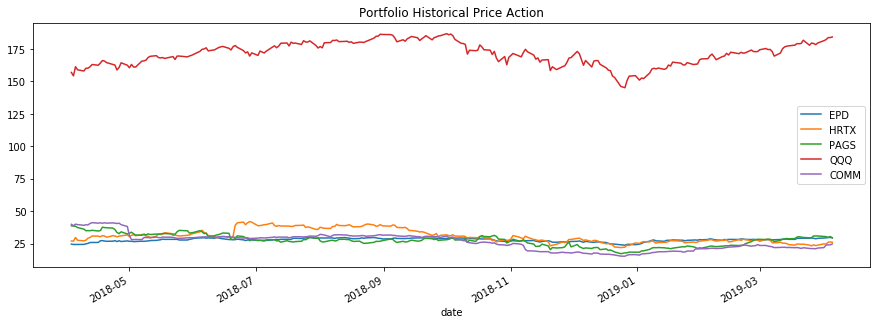

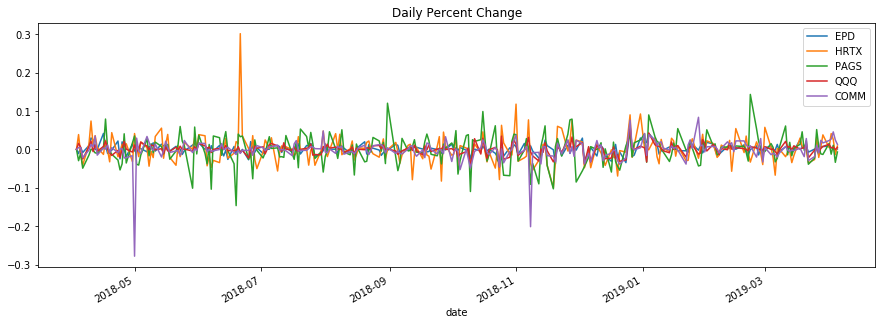

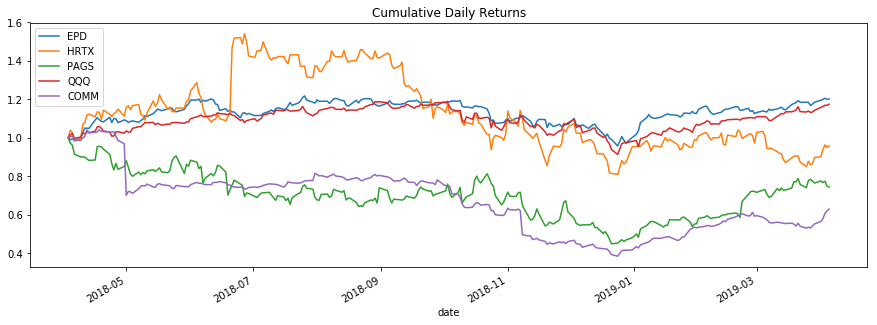

In [9]:
# Plot price action
for sym, data in port.items():
    data['open'].plot(figsize=(15,5), label=sym,legend=True)
plt.title('Portfolio Historical Price Action')
plt.show()

# Plot daily pct change
for sym, data in port_rets.items():
    data['pct change'].plot(figsize=(15,5), label=sym,legend=True)
plt.title('Daily Percent Change')
plt.show()

# Plot cumulative returns
for sym, data in port_rets.items():
    data['cumulative daily'].plot(figsize=(15,5), label=sym,legend=True)
    x = data['cumulative daily']
plt.title('Cumulative Daily Returns')
plt.show()

# Statistical Measurements

In [10]:
# time_of_price={open, high, low, close, adjusted close, volume}
def get_var(ticker, param='adjusted close'):
    return np.var(port[ticker][param]), np.std(port[ticker][param])

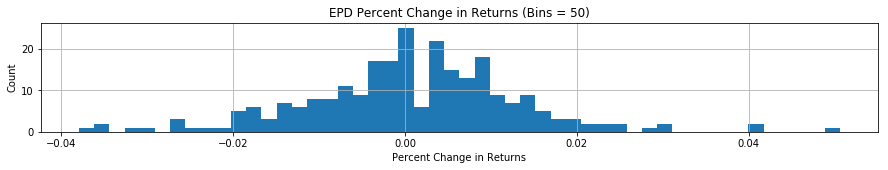

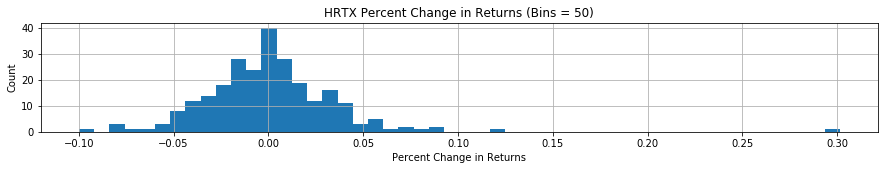

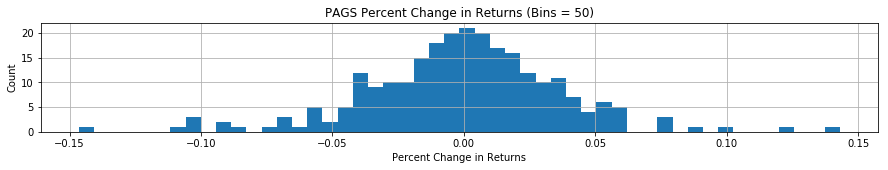

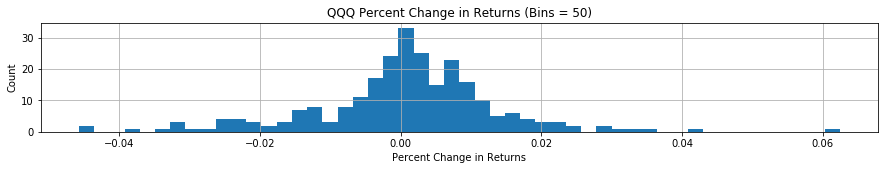

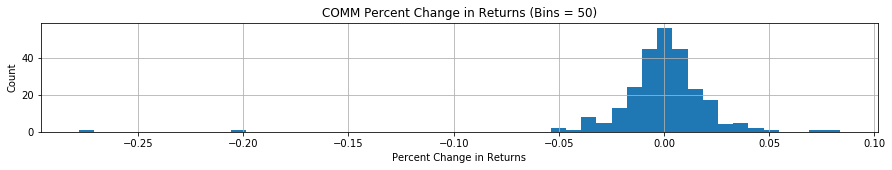

In [11]:
bins = 50
for sym, data in port_rets.items():
    port_rets[sym]['pct change'].hist(bins=bins, figsize=(15,2))
    plt.title(f'{sym} Percent Change in Returns (Bins = {bins})')
    plt.xlabel('Percent Change in Returns')
    plt.ylabel('Count')
    plt.show()

In [12]:
# Plot the volatility of an asset in the portfolio.
# show_price: if True, also plots price data of the stock.
# show_benchmark: if True, also plots volatility of S&P 500.
def plot_port_vol(ticker, min_periods=25, show_price=False, show_bench=False):
    
    global price, bench_vol
    price= None
    bench_vol= None

    # Get the asset volatility and optionally the S&P volatility and price data of the asset.    
    vol = port_rets[ticker]['pct change'].rolling(min_periods).std()*np.sqrt(min_periods)
    if show_bench:
        start = str(port_rets[ticker].index[0])[:-9]
        end = str(port_rets[ticker].index[-1])[:-9]
        bench_data = get_data('SPY', start_date= start, end_date= end)
        bench_rets = calculate_returns(bench_data)
        bench_vol = bench_rets['pct change'].rolling(min_periods).std()*np.sqrt(min_periods)
    if show_price:
        price = port[ticker]['close']
    
    fig, ax1 = plt.subplots(figsize=(12,3))
    
    vol_color = 'tab:red'
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Percent')
    ax1.plot(vol, color=vol_color, label=ticker)
    ax1.legend(loc=1)
    
    if show_bench:
        bench_color='tab:orange'
        ax1.plot(bench_vol, color=bench_color, label='S&P')
        ax1.legend(loc=1)
    if show_price:
        ax2 = ax1.twinx() # second axes with same x-axis
        price_color = 'tab:blue'
        ax2.set_ylabel(f'{ticker} Price')
        ax2.plot(price, color=price_color, label=f'{ticker} price')
        ax2.tick_params(axis='y', labelcolor=price_color)
        ax2.legend(loc=2)
    vol.dropna()
    asset_mean = vol.mean()
    asset_std_dev = vol.std()
    asset_std_err = vol.sem()
    
    bench_mean = bench_vol.mean()
    bench_std_dev = bench_vol.std()
    bench_std_err = bench_vol.sem()
    
    fig.tight_layout()
    plt.title(f'{ticker} vs. S&P: Volatility ({min_periods}-Day Rolling Period)')
    plt.show()
        
    vol_stats = pd.DataFrame(index=['mean', 'std dev', 'std err'])
    vol_stats[ticker] = pd.Series((asset_mean, asset_std_dev, asset_std_err), index=vol_stats.index)
    vol_stats['S&P 500'] = pd.Series((bench_mean, bench_std_dev, bench_std_err), index=vol_stats.index)
    
    agree=False
    if asset_mean <= bench_mean and asset_mean + asset_std_err >= bench_mean:
        agree = True
    elif asset_mean >= bench_mean and asset_mean - asset_std_err <= bench_mean:
        agree=True
    
    print(vol_stats) 
    print(f'S&P and {ticker} agree within std error: {agree}')

In [13]:
start = str(port_rets['COMM']['pct change'].index[0])[:-9]
end = str(port_rets['COMM']['pct change'].index[-1])[:-9]

In [16]:
for sym, data in port.items():
    if sym is not 'SPY':
        plot_port_vol(sym, show_bench=True, show_price=True)
        plt.show()

KeyError: 'Time Series (Daily)'

In [17]:
def plot_linreg(asset_1, asset_2, xlabel=None, ylabel=None, visible=True):
    params = stats.linregress(asset_1, asset_2)
    m = params.slope
    b = params.intercept
    x = np.linspace(np.min(asset_1), np.max(asset_1), 500)
    y = m*x + b
    
    if visible:
        plt.scatter(asset_1, asset_2)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.plot(x, y)
        plt.show()
    
    return '%.3f'%(params.rvalue**2), '%.3f'%(params.pvalue), '%.3f'%(params.stderr)

,R squared,p value,std err
EPD/HRTX,0.214,0.206,0.000
EPD/PAGS,0.052,0.201,0.000
EPD/QQQ,0.764,0.197,0.000
EPD/COMM,0.065,0.283,0.000
EPD/SPY,0.710,0.265,0.000
HRTX/PAGS,0.067,0.054,0.000
HRTX/QQQ,0.293,0.092,0.000
HRTX/COMM,0.374,0.063,0.000
HRTX/SPY,0.246,0.116,0.000
PAGS/QQQ,0.063,0.120,0.000


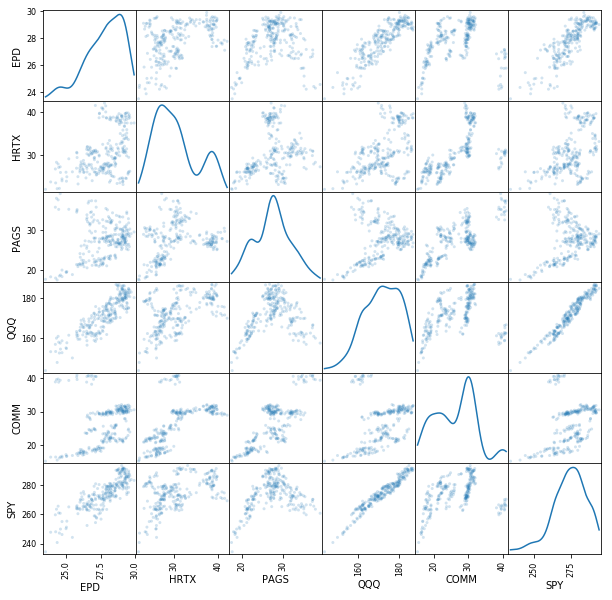

In [20]:
# Plot scatter matrix of portfolio.
close = pd.DataFrame()
for s, d in port.items():
    close[s] = port[s]['close']
pd.plotting.scatter_matrix(close, alpha=0.2,figsize=(10,10), diagonal='kde');

# Plot all linear regressions of the stocks within the portfolio.
hash_combos = []
sym_combos = []

regress_stats = pd.DataFrame(columns=['R squared', 'p value', 'std err'])

#rsq, pval, std

for sym, data in port.items():
    for s, d in port.items():       
        if sym is not s and (hash(sym+s) and hash(s+sym) not in hash_combos):
            rsq,pval,std = plot_linreg(port[sym]['close'], port[s]['close'], visible=False)
            h = hash(sym+s)
            hash_combos.append(h)
            values =pd.Series([rsq, std, pval], index=regress_stats.columns).rename(f'{sym}/{s}')
            regress_stats = regress_stats.append(values)
            
regress_stats

In [21]:
stock = 'COMM'

# Enter start date
start = '2018-04-05'

# Default set to today
end = dt.today().strftime('%Y-%m-%d')

macd, macd_meta = ti.get_macd(stock)
macd = pd.DataFrame(macd)
macd.index = pd.to_datetime(macd.index)

rsi, rsi_meta = ti.get_rsi(stock)
rsi = pd.DataFrame(rsi)
rsi.index = pd.to_datetime(rsi.index)

boll, boll_meta = ti.get_bbands(stock, time_period=60)
boll = pd.DataFrame(boll)
boll.index = pd.to_datetime(boll.index)

ad, ad_meta = ti.get_ad(stock)
ad = pd.DataFrame(ad)
ad.index = pd.to_datetime(ad.index)

obv, obv_meta = ti.get_obv(stock)
obv = pd.DataFrame(obv)
obv.index = pd.to_datetime(obv.index)

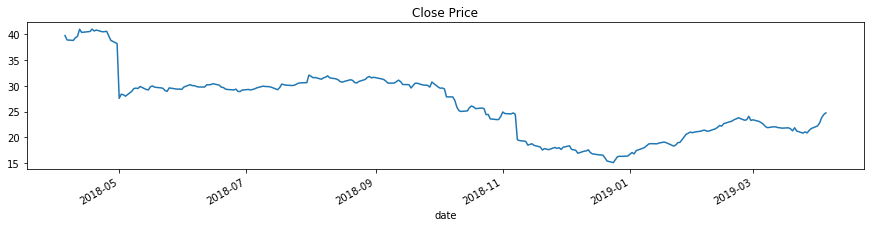

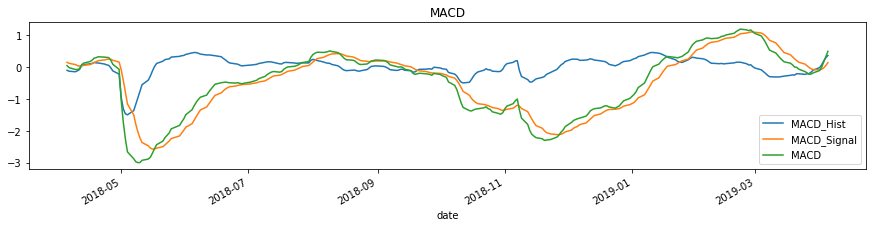

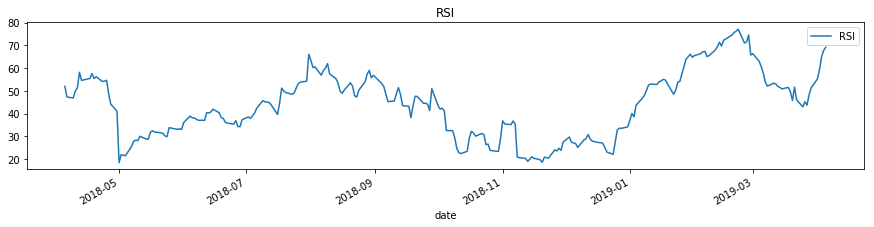

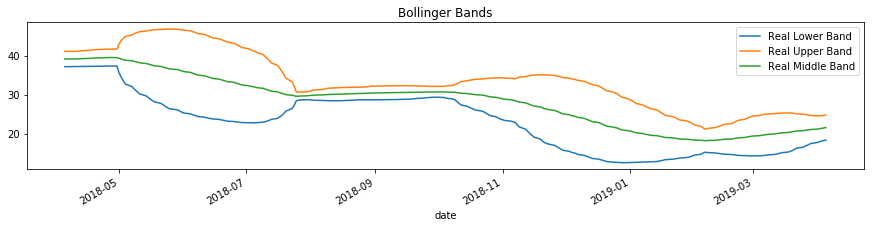

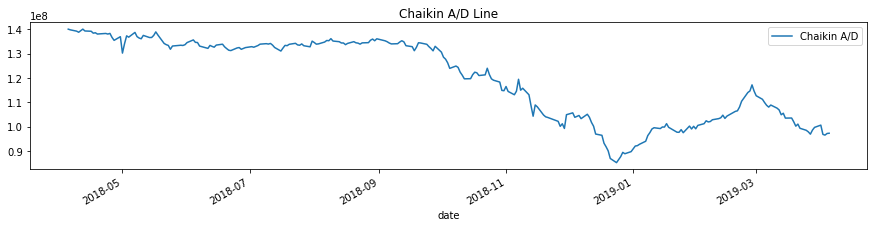

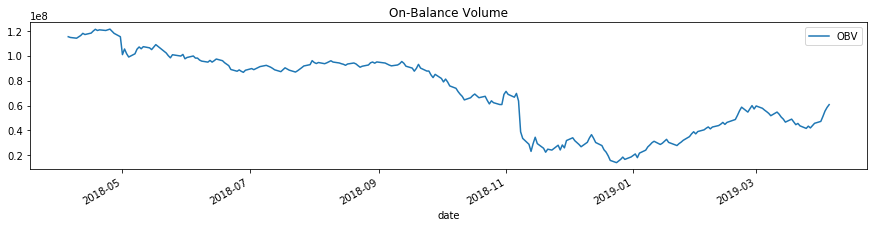

In [24]:
size = (15,3)
port['COMM']['close'][start:end].plot(title='Close Price', figsize=size)
macd[start:end].plot(title= 'MACD', figsize=size);
rsi[start:end].plot(title='RSI', figsize=size);
boll[start:end].plot(title='Bollinger Bands', figsize=size);
ad[start:end].plot(title='Chaikin A/D Line', figsize=size);
obv[start:end].plot(title='On-Balance Volume', figsize=size);

# Under Construction

## Efficiency Ratio

In [ ]:
def eff_rat(symbol, period=7):
    close_data = port[symbol]['close']
    close
    
    return pd.DataFrame()

In [ ]:
close_data = port['EPD']['close']

abs_change = close_data.diff().resample('7D').sum()
#summed_data = close_data.resample('7D')

## Technical Indicator Consolidation Method

In [ ]:
#get_indicator(sym, inter'daily', duration=20, series='close', fast_per=None, slow_per=None, fast_lim=None, slow_lim=None, 
              #sig_per=None, ma=None, fast_ma=None, slow_ma=None, sig_ma=None, t1=None, t2=None, t3=None, upper=None, 
              #lower=None, accel=None, maxim=None)    